# Autoreload 2

In [1]:
%load_ext autoreload
%autoreload 2

# Import Relevant Libraries

In [2]:
import pandas as pd
import datetime
from datetime import timezone
import json
import numpy as np
from pandas.io.json import json_normalize
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from math import pi
import time 
import pickle

from nintendo.nintendo_functions_2 import (   #for api use
    fetch_from_cache_or_api, 
    get_token, 
    get_tweets, 
    store_many_tweets, 
    store_response_tweets, 
    tweet_coll)

from nintendo.trend_radar_functions import (   #for post cleaning
    reset_index, 
    json_to_df, 
    combine_2_dfs,
    add_time_to_df,
    unique_seconds_list, 
    second_groupings, 
    seconds_dict, 
    unique_words_list,
    vectorize_to_df,
    words_df,
    trend_line,
    drop_time_from_df,
    create_dictionary_for_specified_time,
    top_5_dict_to_df,
    radar_plot_creator,
    completed_words_df,
    trend_function,
    radar_function,
    )  

from nintendo.data_cleaning import (  #for cleaning
    create_timestamp_col,
    add_time_from_created,
    create_time_col_19,
    select_relevant_cols, 
    select_relevant_cols_19,
    filter_lang,
    filter_lang_19,
    drop_duplicates,
    unique_hashtag_list,
    unique_link_list,
    unique_ats_list,
    remove_hash_link_at,
    strip_punctuation,
    remove_punctuation,
    make_lower_case,
    get_wordnet_pos,
    lemmatize_text,
    remove_stop_words,
    remove_just_hash,
    vader_sentiment,
   )

# Pulls 100 Tweets at a Time (no repeats)

In [3]:
#store_many_tweets(limit=20)

# View Pulled Tweets in Mongo DB

In [4]:
tweet_coll.count_documents({})

10269

'tweets' (below) is a json file

In [5]:
tweets = list(tweet_coll.find())

# Data Cleaning

Flatten JSON File for embedded dictionaries and store as DF.

In [6]:
tweets_norm = json_to_df(tweets)

Filter for English only (also uses only relevant columns)  
Remove any duplicate rows.

In [7]:
df = filter_lang_19(tweets_norm)

In [8]:
df = drop_duplicates(df)

Add a .time. column showing H:M:S    

In [9]:
#create_time_col_19(df) #works.. but creates a datetime.. we want str

In [12]:
add_time_from_created(df)

#### Explore the Data

In [14]:
len(df)

10160

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10160 entries, 0 to 10268
Data columns (total 5 columns):
user.id       10160 non-null int64
text          10160 non-null object
lang          10160 non-null object
created_at    10160 non-null object
.time.        10160 non-null object
dtypes: int64(1), object(4)
memory usage: 796.2+ KB


In [16]:
df.isna().sum()

user.id       0
text          0
lang          0
created_at    0
.time.        0
dtype: int64

In [17]:
print(df['.time.'].min())
print(df['.time.'].max())

16:07:00
17:04:59


#### Text Cleaning

Remove any words starting with: #, @, or http and put cleaned text into new 'text2' column.

In [18]:
remove_hash_link_at(df)

Remove punctuation & stop words, make text all lower case, lemmatize all words.

In [19]:
remove_punctuation(df)

In [20]:
make_lower_case(df)

In [21]:
lemmatize_text(df)

In [22]:
remove_stop_words(df)

Remove http again (some links may have had symbol infront of it and not been removed the first time)

In [23]:
remove_just_hash(df)

In [24]:
df = reset_index(df)

# End Data Cleaning

# Vader Sentiment

In [25]:
vader_output = vader_sentiment(df)

In [26]:
vader_output[0:6]

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'compound': 0.1027},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'compound': 0.1027},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

# End Vader Sentiment

# Initial Setup for Graphs

Combine vader sentiments into df

In [27]:
df = combine_2_dfs(reset_index(df),json_to_df(vader_output))

List of every unique second in the data

In [28]:
df = df.sort_values(by='.time.')

In [29]:
unique_sec_list = unique_seconds_list(df)

Grouping by every 5 seconds for trend line

In [30]:
df[str(5)+'_seconds'] = df['.time.'].map(seconds_dict(5, unique_sec_list))

NOTE: Trend line does not include empty seconds

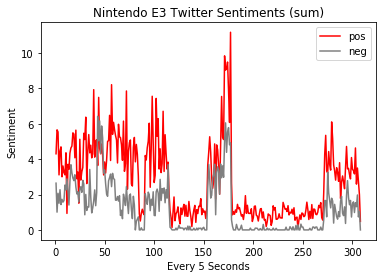

In [31]:
trend_line(df, 5, 'sum')

# LSM YOU ARE HERE - WORK ON GROUPS

Luigi's Mansion = 07:25 through 10:45   
Link's Awakening = 12:50 through 14:55   
Cadence of Hyrule = 32:30 through 33:25   
Breath of the Wild = 42:55 through 43:45   

All relevant groupings for four 2019 games of interest:   
CREATE DICTIONARY OF GROUP TO TIME

In [33]:
type(df['.time.'][0])

str

In [35]:
df.loc[df['.time.'] == '16:07:00']

,level_0,index,user.id,text,lang,created_at,.time.,text2,compound,neg,neu,pos,5_seconds
7403,7403,7493,2416539014,#NintendoE3 Are the Luigi's Mansion games any ...,en,Tue Jun 11 16:07:00 +0000 2019,16:07:00,luigis mansion game good,0.4404,0.000,0.707,0.293,1
7401,7401,7491,2681468120,LUIGI'S MANSION 3 HELLLLLL YEAHHHHHHHH\n\n#e3 ...,en,Tue Jun 11 16:07:00 +0000 2019,16:07:00,luigis mansion 3 hellllll yeahhhhhhhh,0.0000,0.000,1.000,0.000,1
7400,7400,7490,236546300,RT @Nibellion: Holy shit #NintendoDirect http...,en,Tue Jun 11 16:07:00 +0000 2019,16:07:00,rt holy shit,-0.5574,0.419,0.581,0.000,1
7399,7399,7489,987143124974690304,RT @ZeldaUniverse: BOWSER MEETS BOWSER #Ninten...,en,Tue Jun 11 16:07:00 +0000 2019,16:07:00,rt bowser meet bowser,0.0000,0.000,1.000,0.000,1
7398,7398,7488,839162843324891138,Luigi's Mansion 3 up next. #NintendoDirect,en,Tue Jun 11 16:07:00 +0000 2019,16:07:00,luigis mansion 3 next,0.0000,0.000,1.000,0.000,1
7397,7397,7487,40618694,Dragon Quest!! I love this. My heart. #Nintend...,en,Tue Jun 11 16:07:00 +0000 2019,16:07:00,dragon quest love heart,0.6988,0.000,0.626,0.374,1
7396,7396,7486,814210764944928773,RT @KittyCouch: GIVE ME ANIMAL CROSSING! OR GI...,en,Tue Jun 11 16:07:00 +0000 2019,16:07:00,rt give animal cross give death,-0.7586,0.315,0.685,0.000,1
7395,7395,7485,261968159,#LuigisMansion3 let's go #NintendoDirect #E320...,en,Tue Jun 11 16:07:00 +0000 2019,16:07:00,let go,0.0000,0.000,1.000,0.000,1
7394,7394,7484,4825523593,RT @Nibellion: Bowser runs Nintendo now #Ninte...,en,Tue Jun 11 16:07:00 +0000 2019,16:07:00,rt bowser run nintendo,0.0000,0.000,1.000,0.000,1
7393,7393,7483,62211706,RT @LiKovacs: Time for Luigi's Mansion 3\n\n#N...,en,Tue Jun 11 16:07:00 +0000 2019,16:07:00,rt time luigis mansion 3,0.0000,0.000,1.000,0.000,1


In [ ]:
#df.loc[df['time'] == '16:07:00']

# Experimental

In [ ]:
tweet_df = pd.DataFrame(tweets)

In [ ]:
print(tweet_df['created_at'].min())
print(tweet_df['created_at'].max())


In [ ]:
tweet_df['text']

In [ ]:
tweet_df.iloc[-1]['created_at']

In [ ]:
tweet_df['timestamp'] = tweet_df['created_at'].apply(pd.Timestamp)

In [ ]:
tweet_df.loc[tweet_df['timestamp'] == 'Tue Jun 11 16:33:25 +0000 2019']